## 1 – Configuração de ambiente  
Importa bibliotecas, define device e hiperparâmetros centrais.

In [9]:
import torch, random, itertools, math
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

In [43]:
device = "cuda" if torch.cuda.is_available() else "cpu"

IMG_SIZE = 64
BATCH_SIZE = 256
EPOCHS = 10
MARGIN = 1.0
PAIRS_PER_EPOCH = 5000

## 2 – Omniglot  
Baixa o conjunto e faz split: 30 alfabetos para treino, resto para teste (zero-shot).

In [ ]:
transform = transforms.Compose([
    transforms.Grayscale(),          # garante 1 canal
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

root = "./data/omniglot"
full = datasets.Omniglot(root, download=True, background=True, transform=transform)

# background=True traz 30 alfabetos; background=False traz 20 alfabetos extras
# Usaremos ambos para ter 50 alfabetos, depois dividimos manualmente
extra = datasets.Omniglot(root, download=True, background=False, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [54]:
from collections import defaultdict

def split_by_alphabet(ds):
    alpha2imgs = defaultdict(list)
    for img, target in ds:
        alpha = ds._characters[target].split("/")[0]
        alpha2imgs[alpha].append((img, target))
    return alpha2imgs

train_alpha = split_by_alphabet(full)          # 30 alfabetos
test_alpha  = split_by_alphabet(extra)         # 20 alfabetos (unseen)

## 3 – PairDataset  
Gera pares (img1, img2, label) on-the-fly: label = 0 positivos, 1 negativos.

In [55]:
class PairDataset(Dataset):
    def __init__(self, alpha2imgs, pairs_per_epoch=5000):
        self.alpha2imgs = alpha2imgs
        self.classes = list(itertools.chain(*[[(a, i) for i in range(len(v))]
                                              for a, v in alpha2imgs.items()]))
        self.pairs_per_epoch = pairs_per_epoch

    def __len__(self):
        return self.pairs_per_epoch

    def __getitem__(self, idx):
        same = random.randint(0, 1) == 0
        if same:
            alpha = random.choice(list(self.alpha2imgs.keys()))
            imgs = random.sample(self.alpha2imgs[alpha], 2)
        else:
            alpha1, alpha2 = random.sample(list(self.alpha2imgs.keys()), 2)
            imgs = [random.choice(self.alpha2imgs[alpha1]),
                    random.choice(self.alpha2imgs[alpha2])]
        (img1, _), (img2, _) = imgs
        label = torch.tensor(float(not same), dtype=torch.float32)  # 0=sim,1=dif
        return img1, img2, label

dataset = PairDataset(train_alpha, pairs_per_epoch=PAIRS_PER_EPOCH)
train_loader = DataLoader(
    dataset=dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

In [56]:
dataset[0]

(tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]),
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]),
 tensor(0.))

## 4 – Rede Siamese  
Encoder convolucional → vetor de 4096 dim, compartilhado nos dois ramos.

In [46]:
class SiameseNet(nn.Module):
    def __init__(self):
        super().__init__()

        # ↓--- CNN corrigida ---↓
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, 10), nn.ReLU(), nn.MaxPool2d(2),   # 64→55→27
            nn.Conv2d(64, 128, 7), nn.ReLU(), nn.MaxPool2d(2),   # 27→21→10
            nn.Conv2d(128,128, 4), nn.ReLU(), nn.MaxPool2d(2),  # 10→7→3
            # ❶ kernel 4 dava erro (3 × 3); reduza para 3 e use padding=1
            nn.Conv2d(128,256, 3, padding=1), nn.ReLU(),        # 3→3
            # ❷ adapta qualquer tamanho de entrada para 1 × 1
            nn.AdaptiveAvgPool2d(1)
        )

        # 256 canais × 1 × 1  → 4096
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 4096),
            nn.Sigmoid()
        )

    def forward_once(self, x):
        x = self.cnn(x)
        return self.fc(x)

    def forward(self, x1, x2):
        return self.forward_once(x1), self.forward_once(x2)

model = SiameseNet().to(device)

## 5 – Contrastive Loss + Treino  
Minimiza distância euclidiana para pares iguais, empurra para MARGIN para diferentes.

In [47]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin):
        super().__init__()
        self.margin = margin

    def forward(self, out1, out2, label):
        d = (out1 - out2).pow(2).sum(1).sqrt()
        loss = (1 - label) * d.pow(2) + label * torch.clamp(self.margin - d, min=0).pow(2)
        return loss.mean()

In [48]:
criterion = ContrastiveLoss(MARGIN)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

scaler = torch.amp.GradScaler()

for epoch in range(EPOCHS):
    model.train()
    cum_loss = 0.0
    for img1, img2, label in train_loader:
        img1, img2, label = (
            img1.to(device, non_blocking=True),
            img2.to(device, non_blocking=True),
            label.to(device, non_blocking=True)
        )

        optimizer.zero_grad(set_to_none=True)

        with torch.cuda.amp.autocast():
            out1, out2 = model(img1, img2)
            loss = criterion(out1, out2, label)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        cum_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS}  Loss {cum_loss/len(train_loader):.4f}")

/tmp/ipykernel_2819024/2510548251.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/10  Loss 0.3554
Epoch 2/10  Loss 0.2545
Epoch 3/10  Loss 0.2452
Epoch 4/10  Loss 0.2392
Epoch 5/10  Loss 0.2401
Epoch 6/10  Loss 0.2377
Epoch 7/10  Loss 0.2326
Epoch 8/10  Loss 0.2358
Epoch 9/10  Loss 0.2274
Epoch 10/10  Loss 0.2300


## 6 – Gerador de tarefas N-way K-shot  
Seleciona N classes never-seen, devolve suporte e consultas.

In [49]:
def sample_task(alpha2imgs, N=20, K=1, Q=5):
    classes = random.sample(list(alpha2imgs.keys()), N)
    support, query, labels = [], [], []
    for idx, c in enumerate(classes):
        imgs = random.sample(alpha2imgs[c], K + Q)
        s, q = imgs[:K], imgs[K:]
        support += [(img, idx) for img, _ in s]
        query   += [(img, idx) for img, _ in q]
    return support, query

## 7 – Avaliação: 20-way 1-shot em alfabetos não vistos  
Classifica cada consulta pelo NN mais próximo no set de suporte. Mede acurácia.

In [51]:
def embed(imgs):
    with torch.no_grad():
        return model.forward_once(torch.stack([i for i, _ in imgs]).to(device)).cpu()

def few_shot_accuracy(tasks=200, N=20, K=1, Q=5):
    correct, total = 0, 0
    model.eval()
    for _ in range(tasks):
        support, query = sample_task(test_alpha, N, K, Q)
        sup_emb = embed(support)
        qry_emb = embed(query)
        sup_labels = torch.tensor([lbl for _, lbl in support])
        for i, (q_img, gt) in enumerate(query):
            dists = torch.norm(qry_emb[i] - sup_emb, dim=1)
            pred = sup_labels[dists.argmin()].item()
            correct += int(pred == gt)
            total += 1
    return correct / total

acc = few_shot_accuracy(N=3, K=5)
print(f"20-way 1-shot accuracy: {acc*100:.2f}%")

20-way 1-shot accuracy: 59.37%


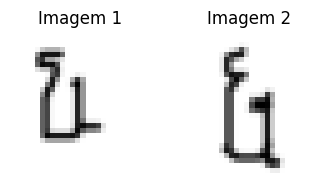

Distância euclidiana: 0.3382
Mesmo caractere? Sim


In [24]:
# Selecionar novo par aleatório
img1, img2, label = pair_dataset[42]

plt.figure(figsize=(4, 2))
plt.subplot(1, 2, 1)
plt.imshow(img1.squeeze() * 0.5 + 0.5, cmap='gray')
plt.title("Imagem 1")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img2.squeeze() * 0.5 + 0.5, cmap='gray')
plt.title("Imagem 2")
plt.axis('off')
plt.show()

# Embeddings e distância
model.eval()
with torch.no_grad():
    emb1, emb2 = model(img1.unsqueeze(0).to(device), img2.unsqueeze(0).to(device))
    dist = F.pairwise_distance(emb1, emb2).item()

print(f"Distância euclidiana: {dist:.4f}")
print(f"Mesmo caractere? {'Sim' if label.item() == 1 else 'Não'}")